In [47]:
import numpy as np
from pyscf import gto, scf, mp, lo
from pyscf.tools import cubegen
import matplotlib.pyplot as plt
import datetime
from scipy.spatial.distance import cdist

In [2]:
data = np.load("../../data/md17_benzene2017.npz", allow_pickle=True)
R = data["R"][2].tolist()
Z = data["z"]

In [3]:
mol = gto.Mole()
atom_data = list(zip(Z, R))
mol.atom = atom_data
mol.basis = "ccpvdz"
mol.build()

In [4]:
hf_result = scf.HF(mol).run()
hf_1dm = hf_result.make_rdm1()
hf_2dm = hf_result.make_rdm2()
time1 = datetime.datetime.now()

hf_atomic_orbitals = mol.intor("int1e_ovlp")
mo_coeff = hf_result.mo_coeff
hf_energy = hf_result.e_tot
hf_atomic_orbitals.shape

converged SCF energy = -230.72180856824


(114, 114)

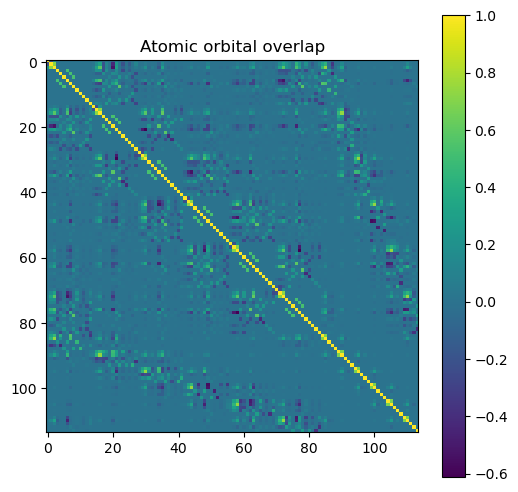

In [5]:
fig_ao = plt.figure(figsize=(6,6))
ax_ao = fig_ao.add_subplot(111)
ax_ao.set_title("Atomic orbital overlap")
image_ao = ax_ao.imshow(hf_atomic_orbitals)
plt.colorbar(image_ao)
plt.show()

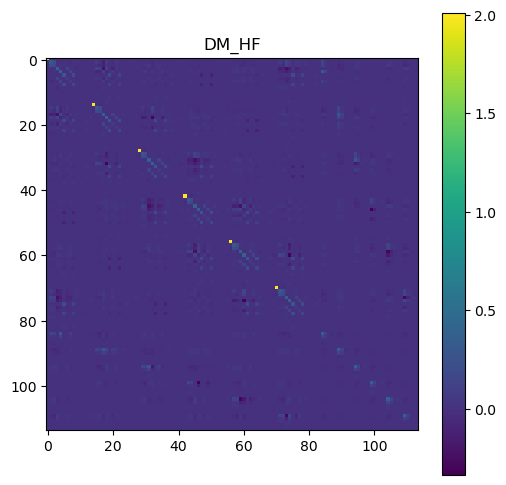

In [6]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_title('DM_HF')
image = ax.imshow(hf_1dm)
plt.colorbar(image)
plt.show()

**Fourier transform of HF_DM**

In [7]:
hf_dm_fft = np.abs(np.fft.fft2(hf_1dm))

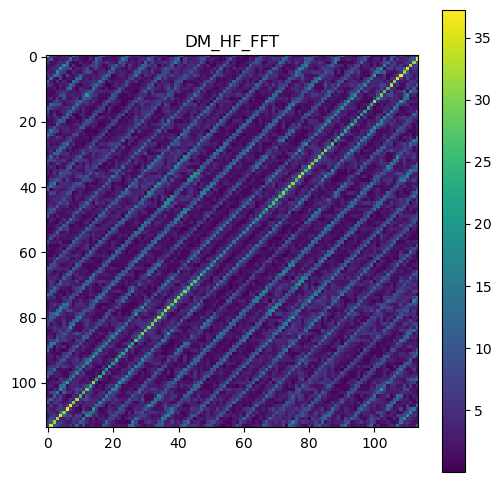

In [8]:
fig_fft = plt.figure(figsize=(6, 6))
ax_fft = fig_fft.add_subplot(111)
ax_fft.set_title('DM_HF_FFT')
image_fft = ax_fft.imshow(hf_dm_fft)
plt.colorbar(image_fft)
plt.show()

In [9]:
hf_h_ij = mol.intor("int1e_nuc") + mol.intor("int1e_kin")
hf_h_ijkl = mol.intor("int2e")
hf_energy_core = np.einsum("pq,qp", hf_h_ij, hf_1dm)
hf_energy_elec = hf_energy_core + 0.5 * np.einsum("pqrs,pqrs", hf_h_ijkl, hf_2dm)
hf_guessed_energy = hf_energy_elec + mol.energy_nuc()

In [10]:
print(f"Correct HF energy: {hf_energy}")
print(f"Guessed HF energy: {hf_guessed_energy}")
print(f"Guessed HF core energy: {hf_energy_core}")

Correct HF energy: -230.72180856824022
Guessed HF energy: -230.7218085682396
Guessed HF core energy: -712.8964911524965


**Moller Plesset Perturbation theory**

In [11]:
mp2_result = mp.MP2(hf_result).run()
mp2_1dm = mp2_result.make_rdm1(ao_repr=False)
#mp2_2dm = mp2_result.make_rdm2(ao_repr=True)
mp2_energy = mp2_result.e_tot
print(mp2_1dm)

E(MP2) = -231.520738608373  E_corr = -0.798930040133306
E(SCS-MP2) = -231.498321360147  E_corr = -0.77651279190701
[[ 1.99982338e+00  1.94323560e-07  5.00366072e-07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.94323560e-07  1.99982115e+00 -4.70854197e-08 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.00366072e-07 -4.70854197e-08  1.99982043e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  7.05906312e-04
   2.34300666e-07  4.35542255e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.34300666e-07
   7.06390230e-04  1.31877106e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.35542255e-07
   1.31877106e-06  3.69414875e-04]]


1.9846067824200486


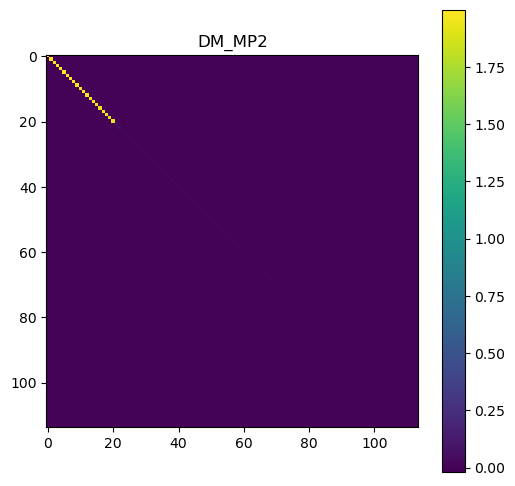

In [12]:
fig_mp2 = plt.figure(figsize=(6, 6))
ax_mp2 = fig_mp2.add_subplot(111)
ax_mp2.set_title('DM_MP2')
print(mp2_1dm[6][6])
image_mp2 = ax_mp2.imshow(mp2_1dm)
plt.colorbar(image_mp2)
plt.imshow(mp2_1dm)

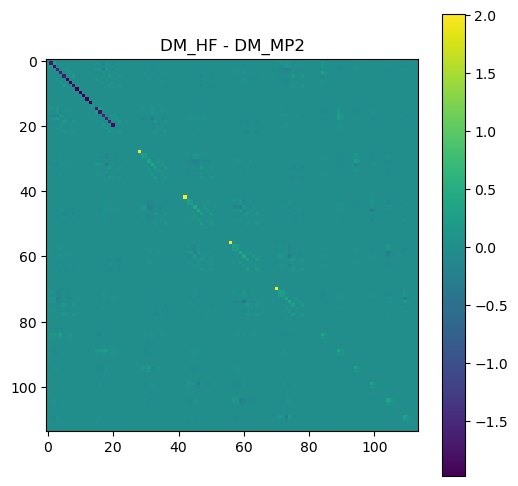

In [13]:
fig_diff = plt.figure(figsize=(6, 6))
ax_diff = fig_diff.add_subplot(111)
ax_diff.set_title('DM_HF - DM_MP2')
image_diff = ax_diff.imshow(hf_1dm - mp2_1dm)
plt.colorbar(image_diff)
plt.show()

In [14]:
mp2_h_ij = mol.intor("int1e_nuc") + mol.intor("int1e_kin")
mp2_h_ijkl = mol.intor("int2e")
mp2_energy_core = np.einsum("pq,qp", mp2_h_ij, mp2_1dm)
#mp2_energy_elec = mp2_energy_core + 0.5 * np.einsum("pqrs,pqrs", mp2_h_ijkl, mp2_2dm)
#mp2_guessed_energy = mp2_energy_elec + mol.energy_nuc()

In [15]:
print(f"Correct MP2 energy: {mp2_energy}")
#print(f"Guessed MP2 energy: {mp2_guessed_energy}")
print(f"Guessed MP2 core energy: {mp2_energy_core}")

Correct MP2 energy: -231.52073860837348
Guessed MP2 core energy: -593.9953861355988


**Creating H2O test data**

In [16]:
h2 = gto.Mole()
h2.atom = [['H', (0, 2, 0)], ['H', (2, 0, 0)]]
h2.basis = 'ccpvdz'
h2.unit = 'B'
h2.build()
hf_h2 = scf.RHF(h2).run()
mo_coeff = hf_h2.mo_coeff

converged SCF energy = -1.00279878118765


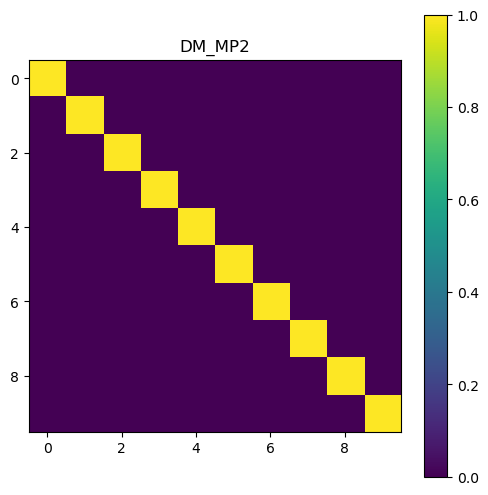

In [17]:
hf_h2_1dm = hf_h2.make_rdm1()
S = h2.intor("int1e_ovlp")
S_transformed = mo_coeff.T @ S @ mo_coeff
fig_h2 = plt.figure(figsize=(6, 6))
ax_h2 = fig_h2.add_subplot(111)
ax_h2.set_title('DM_MP2')
image_h2 = ax_h2.imshow(S_transformed)
plt.colorbar(image_h2)

E(MP2) = -1.03837776403666  E_corr = -0.0355789828490124
E(SCS-MP2) = -1.04549356060646  E_corr = -0.0426947794188149


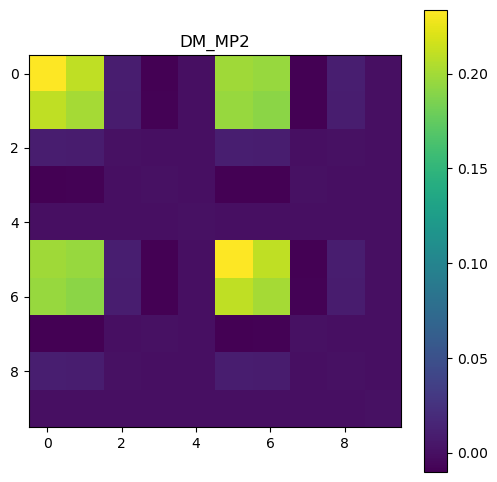

In [18]:
h2_mp2 = mp.MP2(hf_h2).run()
h2_mp2_1dm = h2_mp2.make_rdm1(ao_repr=False)
h2_mp2_1dm = mo_coeff @ h2_mp2_1dm @ mo_coeff.T
fig_h2 = plt.figure(figsize=(6, 6))
ax_h2 = fig_h2.add_subplot(111)
ax_h2.set_title('DM_MP2')
image_h2 = ax_h2.imshow(h2_mp2_1dm)
plt.colorbar(image_h2)

**Plotting electron density for H2O**

In [19]:
ticks = 30
lane = np.linspace(-3, 3, ticks)
x_center = 1
y_center = 1
xyz_points = np.array([[x + x_center, y + y_center, 0] for x in lane for y in lane])


def density_matrix_pointwise(coords, mol, dm, return_type="dm"):
    ao_vals = np.array(mol.eval_ao("GTOval_sph", coords))
    n_coords = len(coords)
    n_orbitals = ao_vals.shape[-1]
    ao_vals = ao_vals.reshape(n_coords, 1, n_orbitals)
    #ao_vals_pointwise = np.matmul(ao_vals_dagger, ao_vals)
    #ao_vals_pointwise = [[coords[i].tolist(), ao_vals_pointwise[i].tolist()] for i in range(n_coords)]
    if return_type == "ao_vals":
        return ao_vals
    elif return_type == "density":
        res = []
        for i in range(len(coords)):
            [x, y, _] = coords[i]
            ao_vals_for_point = ao_vals[i].flatten()
            z = np.einsum("ij,i,j", dm, ao_vals_for_point, ao_vals_for_point)
            res.append([x, y, z])
        res = np.array(res)
        return res
    return ao_vals

dm = hf_h2_1dm
density_pointwise = density_matrix_pointwise(xyz_points, h2, dm, "density")
X = density_pointwise[:, 0]
Y = density_pointwise[:, 1]
Z = density_pointwise[:, 2]
X = X.reshape(ticks, ticks)
Y = Y.reshape(ticks, ticks)
Z = Z.reshape(ticks, ticks)

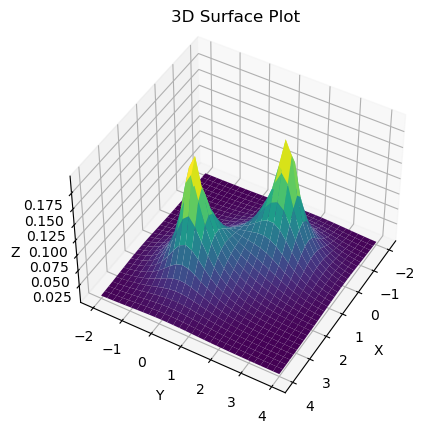

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface Plot')
ax.view_init(45, 30)
plt.show()

In [21]:
ticks = 30
coords = [[x, y, 0] for x in range(ticks) for y in range(ticks)]

In [22]:
cutoff = 5
dist_matrix = cdist(coords, coords)
idx = np.arange(len(coords))
neighbour_coords = (dist_matrix < cutoff) * idx[np.newaxis, :]
neighbour_coords[neighbour_coords == 0.0] = 1500

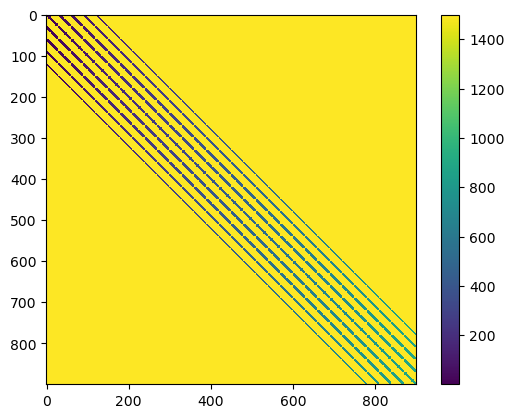

In [23]:
plt.imshow(neighbour_coords, cmap='viridis', interpolation='nearest')

# Add colorbar for reference (optional)
plt.colorbar()

# Show the plot
plt.show()

**TensorFlow tests**

In [48]:
import tensorflow as tf
basis = "ccpvdz"

In [25]:
def hartree_fock_call(R, coords):
    mol = gto.M()
    mol.atom = list(zip([1, 1], R))
    mol.basis = basis
    mol.build()
    ao_vals = np.array(mol.eval_ao("GTOval_sph", coords))
    # shape of ao_vals: (n_coords, n_aovals)
    return ao_vals

def hartree_fock_tensor_call(R_tensor, coords):
    n = len(R_tensor)
    return np.array([hartree_fock_call(R_tensor[i], coords) for i in range(n)])


def call(inputs):
    out = tf.numpy_function(hartree_fock_tensor_call, inp=inputs, Tout=tf.float32)
    return out

In [44]:
R_tensor = [[0, 0, 0], [0.5, 0, 0]]
R_tensor = np.array(R_tensor)
R_tensor = R_tensor.reshape((1, 2, 3))
R_tensor.shape
coords = np.array(R_tensor)
inputs = (R_tensor, coords)
out = call(inputs)
coords_neighbors_idx = np.zeros(2, dtype=np.int32)
out = out, coords_neighbors_idx

In [45]:
def next_call(inputs):
    out, coords_neighbors_idx = inputs
    out_transformed = out
    print(out_transformed.shape)
    n_batch, n_grid, n_ao = out_transformed.shape
    out_dummy = np.zeros(shape=(n_batch, n_grid + 1, n_ao))
    out_dummy[:, :n_grid, :] = out_transformed
    messages = tf.gather(out_dummy, coords_neighbors_idx)
    messages = tf.reduce_sum(messages, axis=-2)
    out = out_transformed + messages
    return out

In [46]:
next_call(out)

(1, 1, 10)


<tf.Tensor: shape=(1, 2, 10), dtype=float64, numpy=
array([[[ 0.91745577,  0.28540658,  0.        ,  0.79785704,
          0.        ,  0.43888593,  0.25595388, -0.78785992,
          0.41691752,  0.        ],
        [ 0.91745577,  0.28540658,  0.        ,  0.79785704,
          0.        ,  0.43888593,  0.25595388, -0.78785992,
          0.41691752,  0.        ]]])>